
--- Data Cleaning Summary ---
Original Data Rows: 17500
Cleaned Data Rows: 17449
Rows Removed: 51
Epoch 1/250
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.0637 - val_loss: 0.1461 - learning_rate: 0.0010
Epoch 2/250
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2690 - val_loss: 0.0350 - learning_rate: 0.0010
Epoch 3/250
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1613 - val_loss: 0.0224 - learning_rate: 0.0010
Epoch 4/250
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1239 - val_loss: 0.0229 - learning_rate: 0.0010
Epoch 5/250
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1045 - val_loss: 0.0173 - learning_rate: 0.0010
Epoch 6/250
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0986 - val_loss: 0.0185 - learning_rate: 0.0010
Epoch 7/250
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0922 - val_loss: 0.0162 - learning_rate: 0.0010
Epoch 8/250
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0888 - val_loss: 0.0171 - learning_rate: 0.0010
Epoch 9/250
2

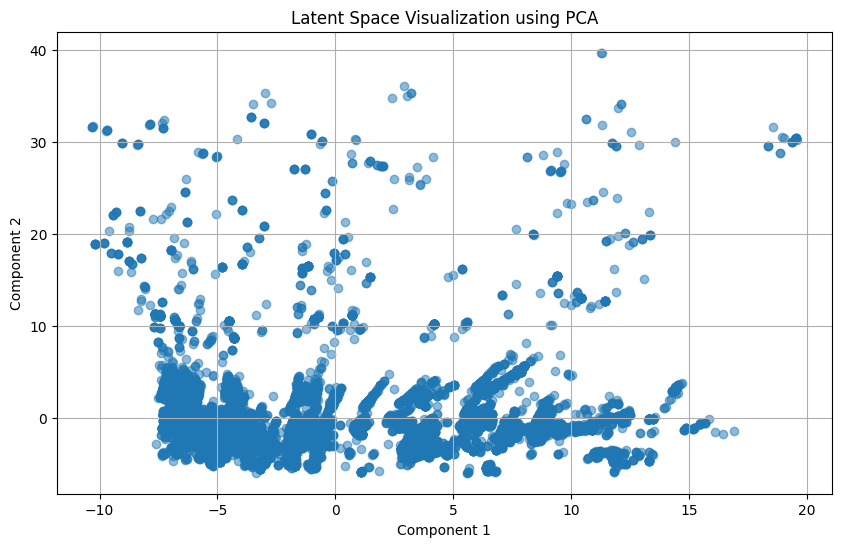

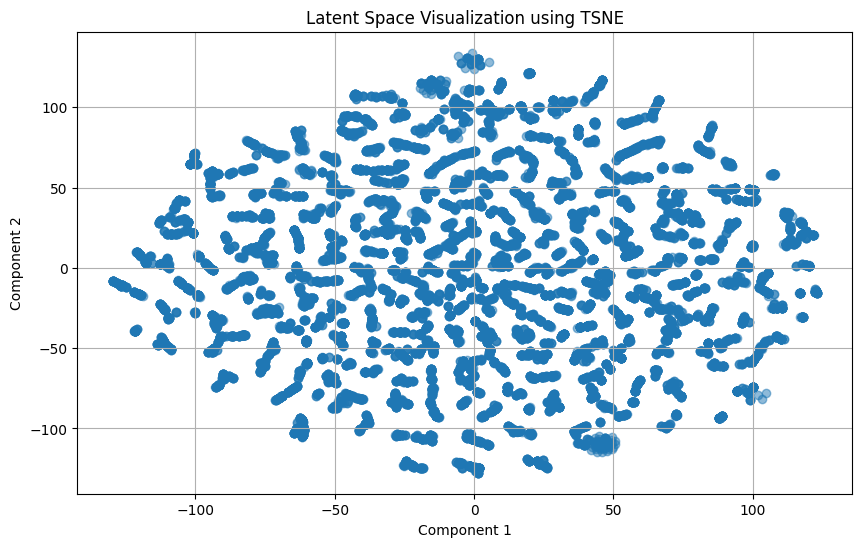

In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import pickle
import matplotlib.pyplot as plt
import logging
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def create_comprehensive_autoencoder(input_dim):
    input_layer = tf.keras.layers.Input(shape=(input_dim,))

    # Encoder
    encoded = tf.keras.layers.Dense(128, activation='leaky_relu')(input_layer)
    encoded = tf.keras.layers.BatchNormalization()(encoded)
    encoded = tf.keras.layers.Dropout(0.2)(encoded)

    encoded = tf.keras.layers.Dense(64, activation='leaky_relu')(encoded)
    encoded = tf.keras.layers.BatchNormalization()(encoded)
    encoded = tf.keras.layers.Dropout(0.2)(encoded)

    bottleneck = tf.keras.layers.Dense(32, activation='leaky_relu', name='latent_space')(encoded)

    # Decoder
    decoded = tf.keras.layers.Dense(64, activation='leaky_relu')(bottleneck)
    decoded = tf.keras.layers.BatchNormalization()(decoded)
    decoded = tf.keras.layers.Dropout(0.2)(decoded)

    decoded = tf.keras.layers.Dense(128, activation='leaky_relu')(decoded)
    decoded = tf.keras.layers.BatchNormalization()(decoded)
    decoded = tf.keras.layers.Dropout(0.2)(decoded)

    output_layer = tf.keras.layers.Dense(input_dim, activation='linear')(decoded)

    autoencoder = tf.keras.Model(input_layer, output_layer)
    encoder = tf.keras.Model(input_layer, bottleneck)
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    return autoencoder, encoder

def visualize_latent_space(latent_vectors, method='pca'):
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, random_state=42)
    else:
        raise ValueError("Invalid method. Choose 'pca' or 'tsne'.")
    
    transformed = reducer.fit_transform(latent_vectors)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(transformed[:, 0], transformed[:, 1], alpha=0.5)
    plt.title(f'Latent Space Visualization using {method.upper()}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid()
    plt.savefig(f'models/latent_space_{method}.png')
    plt.show()

def plot_training_history(history):
    """
    Generate and save a plot of training and validation loss

    Parameters:
    - history: Model training history
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Autoencoder Model Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Mean Squared Error)')
    plt.legend()
    plt.tight_layout()

    # Ensure models directory exists
    os.makedirs("models", exist_ok=True)

    # Save the plot
    plt.savefig('models/training_loss_plot.png')
    plt.close()


def advanced_data_preprocessing(data):
    """
    Comprehensive data preprocessing pipeline

    Parameters:
    - data: Original DataFrame

    Returns:
    - Preprocessed DataFrame
    """
    # Select relevant columns
    relevant_columns = [
        'temperature', 'windspeed', 'humidity', 'precipitation',
            'dewpoint', 'cloud_cover', 'pressure', 'solar_radiation',
            'sunshine_duration', 'ndvi', 'elevation'
        ]

    # Initial data cleaning
    cleaned_data = data[relevant_columns].copy()

    # Convert to numeric and handle errors
    cleaned_data = cleaned_data.apply(pd.to_numeric, errors='coerce')

    # Remove rows with NaN values
    cleaned_data = cleaned_data.dropna()

    # Additional preprocessing steps
    def additional_cleaning(df):
        # Remove extreme outliers (6 standard deviations)
        for column in df.columns:
            mean = df[column].mean()
            std = df[column].std()
            df = df[
                (df[column] >= mean - 6*std) &
                (df[column] <= mean + 6*std)
            ]
        return df

    cleaned_data = additional_cleaning(cleaned_data)

    # Descriptive statistics before and after cleaning
    print("\n--- Data Cleaning Summary ---")
    print(f"Original Data Rows: {len(data)}")
    print(f"Cleaned Data Rows: {len(cleaned_data)}")
    print(f"Rows Removed: {len(data) - len(cleaned_data)}")

    # Visualization of data distribution before and after cleaning
    def plot_distribution_comparison(original, cleaned, columns):
        plt.figure(figsize=(20, 15))
        for i, column in enumerate(columns, 1):
            plt.subplot(5, 4, i)
            plt.hist(original[column], bins=50, alpha=0.5, label='Original')
            plt.hist(cleaned[column], bins=50, alpha=0.5, label='Cleaned')
            plt.title(column)
            plt.legend()
        plt.tight_layout()
        plt.savefig('distribution_comparison.png')
        plt.close()

    plot_distribution_comparison(data[relevant_columns], cleaned_data, relevant_columns)

    return cleaned_data

def train_comprehensive_anomaly_model(data):
    """
    Train a comprehensive anomaly detection model using all relevant features

    Parameters:
    - data: Full dataset

    Returns:
    - Dictionary with model and scaler
    """
    try:
        # Ensure models directory exists
        os.makedirs("models", exist_ok=True)

        feature_data = advanced_data_preprocessing(data)

        # Convert to numeric and handle errors
        feature_data = feature_data.apply(pd.to_numeric, errors='coerce')

        # Skip if insufficient data
        if len(feature_data) < 500:  # Increased minimum samples
            print("Insufficient data for comprehensive model")
            return None

        # Scale the data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(feature_data.values)

        # Split data (90% train, 10% test)
        X_train, X_test = train_test_split(X_scaled, test_size=0.1, random_state=42)

        # Create and train autoencoder
        input_dim = X_scaled.shape[1]
        autoencoder,encoder = create_comprehensive_autoencoder(input_dim)

        # Advanced callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            min_delta=0.0001
        )

        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=0.00001
        )

        # Train the model
        history = autoencoder.fit(
            X_train, X_train,
            epochs=250,  # Increased epochs
            batch_size=64,
            shuffle=True,
            validation_data=(X_test, X_test),
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        # Plot training history
        plot_training_history(history.history)

        # Compute reconstruction error for each sample
        train_pred = autoencoder.predict(X_train)
        test_pred = autoencoder.predict(X_test)

        train_mse = np.mean(np.power(X_train - train_pred, 2), axis=1)
        test_mse = np.mean(np.power(X_test - test_pred, 2), axis=1)

        # Print reconstruction statistics
        print("Training Reconstruction Error:")
        print(f"Mean: {np.mean(train_mse)}")
        print(f"Std: {np.std(train_mse)}")
        print(f"Max: {np.max(train_mse)}")

        print("\nTesting Reconstruction Error:")
        print(f"Mean: {np.mean(test_mse)}")
        print(f"Std: {np.std(test_mse)}")
        print(f"Max: {np.max(test_mse)}")

        # Save comprehensive model
        model_path = "models/comprehensive_autoencoder.keras"
        autoencoder.save(model_path)

        # Save scaler using pickle
        scaler_path = "models/comprehensive_scaler.pkl"
        with open(scaler_path, "wb") as f:
            pickle.dump(scaler, f)

        print(f"Saved comprehensive model to {model_path}")
        print (f"Saved scaler to {scaler_path}")

        # Extract latent vectors for visualization
        latent_vectors = encoder.predict(X_scaled)

        # Visualize latent space
        visualize_latent_space(latent_vectors, method='pca')
        visualize_latent_space(latent_vectors, method='tsne')

        return {
            'autoencoder': autoencoder,
            'scaler': scaler,
            'history': history.history,
            'train_mse': train_mse,
            'test_mse': test_mse
        }

    except Exception as e:
        print(f"Error training comprehensive model: {e}")
        return None


def main():
    """
    Train a comprehensive anomaly detection model

    Returns:
    - Trained comprehensive model
    """
    # Load your dataset
    df = pd.read_excel("og.xlsx")

    # Remove rows with any empty values
    df=df[0:17500]
    df = df.dropna()

    # Train comprehensive model
    comprehensive_model = train_comprehensive_anomaly_model(df)

    return comprehensive_model

if __name__ == "__main__":
    main()

In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


def custom_percentile_rank(values, x):
    """Calculate percentile rank for a value or array."""
    return np.array([np.sum(values <= val) / len(values) * 100 for val in x])


def calculate_similarity(new_place_data, training_data, scaler, weights, autoencoder):
    """Calculate similarity between new place data and training data using autoencoder.

    Parameters:
        - new_place_data: Feature vector of the new place
        - training_data: Scaled feature matrix of training data
        - scaler: Fitted StandardScaler object
        - weights: List of feature weights
        - autoencoder: Trained autoencoder model

    Returns:
        - DataFrame with distances and indices of similar places
    """
    # Scale the new place data
    new_place_scaled = scaler.transform(new_place_data.values.reshape(1, -1))

    # Apply weights
    training_data_weighted = training_data * weights
    new_place_weighted = new_place_scaled * weights

    # Use autoencoder for feature extraction
    training_encoded = autoencoder.predict(training_data_weighted)
    new_place_encoded = autoencoder.predict(new_place_weighted)

    # Compute distances (Euclidean, Cosine Similarity, and Mahalanobis)
    euclidean_distances = np.linalg.norm(training_encoded - new_place_encoded, axis=1)
    cosine_similarities = cosine_similarity(new_place_encoded, training_encoded).flatten()

    # Calculate Mahalanobis distance
    cov_matrix = np.cov(training_encoded, rowvar=False)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    mahalanobis_distances = [distance.mahalanobis(new_place_encoded.flatten(), train.flatten(), inv_cov_matrix) for train in training_encoded]

    # Compute percentile ranks
    euclidean_percentile = custom_percentile_rank(euclidean_distances, euclidean_distances)
    cosine_percentile = custom_percentile_rank(cosine_similarities, cosine_similarities)
    mahalanobis_percentile = custom_percentile_rank(mahalanobis_distances, mahalanobis_distances)

    # Combine results into a DataFrame
    results = pd.DataFrame({
        'Euclidean_Distance': euclidean_distances,
        'Cosine_Similarity': cosine_similarities,
        'Mahalanobis_Distance': mahalanobis_distances,
        'Euclidean_Percentile': euclidean_percentile,
        'Cosine_Percentile': cosine_percentile,
        'Mahalanobis_Percentile': mahalanobis_percentile
    })

    return results


def visualize_similarity_distribution(similarity_results, new_place_data):
    """Create visualizations of similarity distributions."""
    plt.figure(figsize=(15, 5))

    # Euclidean Distance Distribution
    plt.subplot(1, 4, 1)
    sns.histplot(similarity_results['Euclidean_Distance'], kde=True)
    plt.title('Euclidean Distance Distribution')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.axvline(x=similarity_results['Euclidean_Distance'].min(), color='r', linestyle='--',
                label='Most Similar')
    plt.legend()

    # Cosine Similarity Distribution
    plt.subplot(1, 4, 2)
    sns.histplot(similarity_results['Cosine_Similarity'], kde=True)
    plt.title('Cosine Similarity Distribution')
    plt.xlabel('Similarity')
    plt.ylabel('Frequency')
    plt.axvline(x=similarity_results['Cosine_Similarity'].max(), color='r', linestyle='--',
                label='Most Similar')
    plt.legend()

    # Mahalanobis Distance Distribution
    plt.subplot(1, 4, 3)
    sns.histplot(similarity_results['Mahalanobis_Distance'], kde=True)
    plt.title('Mahalanobis Distance Distribution')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.axvline(x=similarity_results['Mahalanobis_Distance'].min(), color='r', linestyle='--',
                label='Most Similar')
    plt.legend()

    # Scatter plot of Euclidean vs Cosine
    plt.subplot(1, 4, 4)
    plt.scatter(similarity_results['Euclidean_Distance'],
                similarity_results['Cosine_Similarity'],
                alpha=0.5)
    plt.title('Euclidean Distance vs Cosine Similarity')
    plt.xlabel('Euclidean Distance')
    plt.ylabel('Cosine Similarity')

    plt.tight_layout()
    plt.savefig('models/similarity_analysis.png')
    plt.close()


def comprehensive_similarity_analysis(new_place_data, training_data, scaler, weights, autoencoder, euclidean_threshold, cosine_threshold, mahalanobis_threshold):
    """Perform comprehensive similarity analysis with dissimilarity check."""
    # Calculate similarity
    similarity_results = calculate_similarity(
        new_place_data, scaler.transform(training_data.values), scaler, weights, autoencoder
    )

    # Check if the new place is dissimilar
    min_euclidean_distance = similarity_results['Euclidean_Distance'].min()
    max_cosine_similarity = similarity_results['Cosine_Similarity'].max()
    min_mahalanobis_distance = similarity_results['Mahalanobis_Distance'].min()

    is_dissimilar = (
        min_euclidean_distance > euclidean_threshold or
        max_cosine_similarity < cosine_threshold or
        min_mahalanobis_distance > mahalanobis_threshold
    )

    # Find top similar places
    top_similar_euclidean = similarity_results.nsmallest(5, 'Euclidean_Distance')
    top_similar_cosine = similarity_results.nlargest(5, 'Cosine_Similarity')
    top_similar_mahalanobis = similarity_results.nsmallest(5, 'Mahalanobis_Distance')

    # Visualize similarity distribution
    visualize_similarity_distribution(similarity_results, new_place_data)

    # Detailed analysis
    analysis_results = {
        'new_place_data': new_place_data,
        'most_similar_euclidean': training_data.iloc[top_similar_euclidean.index],
        'most_similar_cosine': training_data.iloc[top_similar_cosine.index],
        'most_similar_mahalanobis': training_data.iloc[top_similar_mahalanobis.index],
        'similarity_metrics': similarity_results,
        'is_dissimilar': is_dissimilar
    }

    return analysis_results


def main():
    """Compare a new place with training places for similarity and dissimilarity."""
    # Load the scaler
    with open("models/comprehensive_scaler.pkl", "rb") as f:
        scaler = pickle.load(f)

    # Load the autoencoder model
    model_path = "models/comprehensive_autoencoder.keras"
    autoencoder = tf.keras.models.load_model(model_path)

    # Load your training dataset
    training_data = pd.read_excel("og.xlsx")

    # Filter and scale the training data
    relevant_columns = [
        'temperature', 'windspeed', 'humidity', 'precipitation',
        'dewpoint', 'cloud_cover', 'pressure', 'solar_radiation',
        'sunshine_duration', 'ndvi', 'elevation'
    ]
    training_features = training_data[relevant_columns].dropna()

    # Define weights
    weights = np.ones(len(relevant_columns))
    # weights[relevant_columns.index('ndvi')] = 2 # Vegetation Density
    # weights[relevant_columns.index('elevation')] = 2 # Topographical Influence

    # Thresholds for similarity
    euclidean_threshold = 6.5
    cosine_threshold = 0.85
    mahalanobis_threshold = 5.0  # Define a threshold for Mahalanobis distance

    # Load new places dataset
    new_places_data = pd.read_excel("ogtest2.xlsx")
    # new_places_data = new_places_data[17500:]
    new_places_data['location-long'] = new_places_data['longitude'].round(2)
    new_places_data['location-lat'] = new_places_data['latitude'].round(2)

    # Select relevant columns, excluding the index and TARGET
    relevant_columns = [
        'month','location-long', 'location-lat', 'temperature', 'windspeed', 'humidity', 'precipitation',
        'dewpoint', 'cloud_cover', 'pressure', 'solar_radiation',
        'sunshine_duration', 'ndvi', 'elevation'
    ]
    new_places_data = new_places_data[relevant_columns].dropna()

    # Group by LAT and LON and calculate mean for other columns
    grouped_places = new_places_data.groupby(['location-long', 'location-lat', 'month']).agg({
        col: 'mean' for col in new_places_data.columns if col not in ['location-long', 'location-lat', 'month']
    })

    # Reset index to make LAT and LON regular columns again
    grouped_places_reset = grouped_places.reset_index()

    output_results = []

    # Debug: Check the shape of the grouped DataFrame
    print(f"Number of unique LAT,LON combinations: {grouped_places_reset.shape[0]}")

    # Iterate through unique LAT,LON combinations
    for idx, grouped_place_data in grouped_places_reset.iterrows():
        try:
            # Ensure data is in the correct format
            new_place_data_for_analysis = grouped_place_data.drop(['location-long', 'location-lat','month'])

            # Convert the dictionary values into a pandas DataFrame (single row)
            place_data_df = pd.DataFrame(new_place_data_for_analysis).T

            # Calculate similarity and print results
            analysis_results = comprehensive_similarity_analysis(
                place_data_df,
                training_features,
                scaler,
                weights,
                autoencoder,
                euclidean_threshold,
                cosine_threshold,
                mahalanobis_threshold
            )

            # Store results
            output_results.append({
                'LAT': grouped_place_data['location-lat'],
                'LON': grouped_place_data['location-long'],
                'Month': grouped_place_data['month'],
                'Is_Similar': not analysis_results['is_dissimilar'],
                'Cosine_Similarity': analysis_results['similarity_metrics']['Cosine_Similarity'].max(),
                'Euclidean_Distance': analysis_results['similarity_metrics']['Euclidean_Distance'].min(),
                'Mahalanobis_Distance': analysis_results['similarity_metrics']['Mahalanobis_Distance'].min()
            })

        except Exception as e:
            print(f"Error processing row {idx}: {e}")
            print(f"Problematic data: {grouped_place_data}")
            continue

    # Save all results to an Excel file
    output_df = pd.DataFrame(output_results)
    output_file = 'models/similarity_analysis_results.xlsx'
    output_df.to_excel(output_file, index=False)
    print(f"All results saved to {output_file}")


if __name__ == "__main__":
    main()

Number of unique LAT,LON combinations: 12
603/603 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
603/603 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
603/603 ━━━━━━━━━━━━━━━━━━━━ 1s 941us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
603/603 ━━━━━━━━━━━━━━━━━━━━ 1s 915us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
603/603 ━━━━━━━━━━━━━━━━━━━━ 1s 903us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
603/603 ━━━━━━━━━━━━━━━━━━━━ 1s 833us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
603/603 ━━━━━━━━━━━━━━━━━━━━ 1s 968us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
603/603 ━━━━━━━━━━━━━━━━━━━━ 1s 885us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
603/603 ━━━━━━━━━━━━━━━━━━━━ 1s 885us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
603/603 ━━━━━━━━━━━━━━━━━━━━ 1s 932us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
603/603 ━━━━━━━━━━━━━━━━━━━━ 1s 917us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0